In [426]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import waterfall_chart

from list_dict import region_list,region_dict
from format_func import format_th_arrival,format_th_stay_expend,format_th_stay_expend_2020

## Reading data

In [427]:
# arrival number in thailand
th_arrival_2020 = pd.read_excel('data_source/2020_TH_no_of_arrival.xlsx',header=3)
th_arrival_2021 = pd.read_excel('data_source/2021_TH_no_of_arrival.xlsx',header=3)
th_arrival_2022 = pd.read_excel('data_source/2022_TH_no_of_arrival.xlsx',header=3)

# tourist expenditure v staying
th_stay_expend_2018 = pd.read_excel('data_source/tourism_receipts_from_international_tourist_arrivals_q_1_q_4_2018.xlsx'
,header=5,usecols='A:D,F')
th_stay_expend_2019 = pd.read_excel('data_source/tourism_receipts_from_international_tourist_arrivals_q_1_q_4_2019.xlsx'
,header=5,usecols='A:D,F')

th_stay_expend_2020 = pd.read_excel('data_source/tourist_expend_stay_2020.xlsx',header=3,usecols='B:D,N')

## Transforming

In [428]:
# format
th_arrival_2020 = format_th_arrival(th_arrival_2020)
th_arrival_2021 = format_th_arrival(th_arrival_2021)
th_arrival_2022 = format_th_arrival(th_arrival_2022)

th_stay_expend_2018 = format_th_stay_expend(th_stay_expend_2018)
th_stay_expend_2019 = format_th_stay_expend(th_stay_expend_2019)
th_stay_expend_2020 = format_th_stay_expend_2020(th_stay_expend_2020)

In [429]:
# drop columns
th_arrival_2021.drop(columns=['2020P'],inplace=True)
th_arrival_2022.drop(columns=['2021P'],inplace=True)

In [430]:
# merge
th_arrival = pd.merge(th_arrival_2020,th_arrival_2021,how='inner',on='Nationality').merge(th_arrival_2022,how='inner',on='Nationality')
th_arrival = th_arrival[['Nationality', 2019,'2020P', '2021P', '2022P']]

th_arrival.rename(columns={2019:'2019','2020P':'2020','2021P':'2021','2022P':'2022'},inplace=True)

# arrival per region
region_th_arrival = th_arrival.loc[th_arrival['Nationality'].isin(region_list)]

# arrival per country
country_th_arrival = th_arrival.loc[~th_arrival['Nationality'].isin(region_list)]

# stay and spend per country
country_th_stay_spend_2018 = th_stay_expend_2018.loc[~th_stay_expend_2018['Country'].isin(region_list)]
country_th_stay_spend_2019 = th_stay_expend_2019.loc[~th_stay_expend_2018['Country'].isin(region_list)]

# stay and spend per region
region_th_stay_spend_2018 = th_stay_expend_2018.loc[th_stay_expend_2018['Country'].isin(region_list)]
region_th_stay_spend_2019 = th_stay_expend_2019.loc[th_stay_expend_2018['Country'].isin(region_list)]

In [431]:
# melt
region_th_arrival_melt = region_th_arrival.melt(id_vars='Nationality',value_vars=['2019','2020','2021','2022'],
                                                    value_name='num_arrival',var_name='year')

country_th_arrival_melt = country_th_arrival.melt(id_vars='Nationality',value_vars=['2019','2020','2021','2022'],
                                                    value_name='num_arrival',var_name='year')

In [432]:
# scale arrival from unit to million
region_th_arrival_melt['num_arrival'] = region_th_arrival_melt['num_arrival']/1000000
country_th_arrival_melt['num_arrival'] = country_th_arrival_melt['num_arrival']/1000000

#### Percent Change

In [433]:
country_th_arrival_melt.sort_values(by=['Nationality','year'],inplace=True)
region_th_arrival_melt.sort_values(by=['Nationality','year'],inplace=True)
country_th_arrival_melt['pct_change'] = country_th_arrival_melt.groupby('Nationality')['num_arrival'].pct_change()
region_th_arrival_melt['pct_change'] = region_th_arrival_melt.groupby('Nationality')['num_arrival'].pct_change()

In [434]:
percent_change = country_th_arrival_melt.fillna(1).reset_index()
percent_change['pct_change'] = percent_change['pct_change'].apply(lambda x: x*100)
percent_change

,index,Nationality,year,num_arrival,pct_change
0,28,Argentina,2019,0.029498,100.000000
1,73,Argentina,2020,0.012457,-57.770018
2,118,Argentina,2021,0.000382,-96.933451
3,163,Argentina,2022,0.008206,2048.167539
4,37,Australia,2019,0.767162,100.000000
...,...,...,...,...,...
175,162,United Kingdom,2022,0.444432,1049.502108
176,8,Vietnam,2019,1.047663,100.000000
177,53,Vietnam,2020,0.132514,-87.351467
178,98,Vietnam,2021,0.001794,-98.646181


In [435]:
## Chinese expenditure data prep

china_expend_18 = th_stay_expend_2018[th_stay_expend_2018['Country'] == 'China'].reset_index()
china_expend_18['year'] = 2018

china_expend_19 = th_stay_expend_2019[th_stay_expend_2019['Country'] == 'China'].reset_index()
china_expend_19['year'] = 2019

china_expend_20 = th_stay_expend_2020[th_stay_expend_2020['Nationality'] == 'China'].reset_index()
china_expend_20 = china_expend_20.pivot(index='Nationality', columns='Item', values='Values').reset_index()
china_expend_20['year'] = 2020
china_expend_20 = china_expend_20.rename(columns={'Nationality': 'Country', 'Number of Arrivals':'No. of Arrivals','Length of Stay':'Length of Stay (Days)','Per Capita Spending':'Spending per Capita (Baht/Day)','Tourism Receipts':'Total Spend (Mil. Baht)'})
china_expend_20 = china_expend_20.loc[:,['Country','No. of Arrivals','Length of Stay (Days)','Spending per Capita (Baht/Day)','Total Spend (Mil. Baht)','year']]

china_expend = china_expend_18.append(china_expend_19, ignore_index=False)
china_expend = pd.concat([china_expend_18, china_expend_19, china_expend_20])

/var/folders/64/b9lft99n3z7f93x2yz_nmxzr0000gn/T/ipykernel_17137/20795750.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  china_expend = china_expend_18.append(china_expend_19, ignore_index=False)


In [436]:
## Malaysian expenditure data prep

Malay_expend_18 = th_stay_expend_2018[th_stay_expend_2018['Country'] == 'Malaysia'].reset_index()
Malay_expend_18['year'] = 2018

Malay_expend_19 = th_stay_expend_2019[th_stay_expend_2019['Country'] == 'Malaysia'].reset_index()
Malay_expend_19['year'] = 2019

Malay_expend_20 = th_stay_expend_2020[th_stay_expend_2020['Nationality'] == 'Malaysia'].reset_index()
Malay_expend_20 = Malay_expend_20.pivot(index='Nationality', columns='Item', values='Values').reset_index()
Malay_expend_20['year'] = 2020
Malay_expend_20 = Malay_expend_20.rename(columns={'Nationality': 'Country', 'Number of Arrivals':'No. of Arrivals','Length of Stay':'Length of Stay (Days)','Per Capita Spending':'Spending per Capita (Baht/Day)','Tourism Receipts':'Total Spend (Mil. Baht)'})
Malay_expend_20 = Malay_expend_20.loc[:,['Country','No. of Arrivals','Length of Stay (Days)','Spending per Capita (Baht/Day)','Total Spend (Mil. Baht)','year']]

Malay_expend = Malay_expend_18.append(Malay_expend_19, ignore_index=False)
Malay_expend = pd.concat([Malay_expend_18, Malay_expend_19, Malay_expend_20])

/var/folders/64/b9lft99n3z7f93x2yz_nmxzr0000gn/T/ipykernel_17137/3774043795.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Malay_expend = Malay_expend_18.append(Malay_expend_19, ignore_index=False)


In [437]:
## Russian expenditure data prep

ru_expend_18 = th_stay_expend_2018[th_stay_expend_2018['Country'] == 'Russia'].reset_index()
ru_expend_18['year'] = 2018

ru_expend_19 = th_stay_expend_2019[th_stay_expend_2019['Country'] == 'Russia'].reset_index()
ru_expend_19['year'] = 2019

ru_expend_20 = th_stay_expend_2020[th_stay_expend_2020['Nationality'] == 'Russian'].reset_index()
ru_expend_20 = ru_expend_20.pivot(index='Nationality', columns='Item', values='Values').reset_index()
ru_expend_20['year'] = 2020
ru_expend_20 = ru_expend_20.rename(columns={'Nationality': 'Country', 'Number of Arrivals':'No. of Arrivals','Length of Stay':'Length of Stay (Days)','Per Capita Spending':'Spending per Capita (Baht/Day)','Tourism Receipts':'Total Spend (Mil. Baht)'})
ru_expend_20 = ru_expend_20.loc[:,['Country','No. of Arrivals','Length of Stay (Days)','Spending per Capita (Baht/Day)','Total Spend (Mil. Baht)','year']]
ru_expend_20.loc[ ru_expend_20['Country']=='Russian', 'Country' ] = 'Russia'

ru_expend = ru_expend_18.append(ru_expend_19, ignore_index=False)
ru_expend = pd.concat([ru_expend_18, ru_expend_19, ru_expend_20])



/var/folders/64/b9lft99n3z7f93x2yz_nmxzr0000gn/T/ipykernel_17137/3593111664.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ru_expend = ru_expend_18.append(ru_expend_19, ignore_index=False)


In [438]:
## uk expenditure data prep

uk_expend_18 = th_stay_expend_2018[th_stay_expend_2018['Country'] == 'United Kingdom'].reset_index()
uk_expend_18['year'] = 2018

uk_expend_19 = th_stay_expend_2019[th_stay_expend_2019['Country'] == 'United Kingdom'].reset_index()
uk_expend_19['year'] = 2019

uk_expend_20 = th_stay_expend_2020[th_stay_expend_2020['Nationality'] == 'United Kingdom'].reset_index()
uk_expend_20 = uk_expend_20.pivot(index='Nationality', columns='Item', values='Values').reset_index()
uk_expend_20['year'] = 2020
uk_expend_20 = uk_expend_20.rename(columns={'Nationality': 'Country', 'Number of Arrivals':'No. of Arrivals','Length of Stay':'Length of Stay (Days)','Per Capita Spending':'Spending per Capita (Baht/Day)','Tourism Receipts':'Total Spend (Mil. Baht)'})
##uk_expend_20 = uk_expend_20.loc[:,['Country','No. of Arrivals','Length of Stay (Days)','Spending per Capita (Baht/Day)','Total Spend (Mil. Baht)','year']]

uk_expend = uk_expend_18.append(uk_expend_19, ignore_index=False)
uk_expend = pd.concat([uk_expend_18, uk_expend_19, uk_expend_20])



/var/folders/64/b9lft99n3z7f93x2yz_nmxzr0000gn/T/ipykernel_17137/4205067322.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  uk_expend = uk_expend_18.append(uk_expend_19, ignore_index=False)


## Arrival by Nationality

In [439]:
region_arrival = region_th_arrival_melt.groupby('Nationality')['num_arrival'].sum().sort_values()
df_region_arrival = pd.DataFrame({'Nationality': region_arrival.index, 'Total Arrivals': region_arrival.values})
df_region_arrival = df_region_arrival[df_region_arrival['Nationality'] != 'Asean']
df_region_arrival

,Nationality,Total Arrivals
0,Africa,0.292509
1,East Europe,1.030661
2,Middle East,1.281573
3,Oceania,1.410207
4,The Americas,2.603421
5,South Asia,3.914091
6,Europe,11.593394
8,East Asia,37.104347


In [440]:
total_arrival_by_year = region_th_arrival_melt.groupby('year').sum().reset_index()
total_arrival_by_year

/var/folders/64/b9lft99n3z7f93x2yz_nmxzr0000gn/T/ipykernel_17137/4276068652.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_arrival_by_year = region_th_arrival_melt.groupby('year').sum().reset_index()


,year,num_arrival,pct_change
0,2019,51.227347,0.000000
1,2020,8.571517,-7.289376
2,2021,0.487736,-7.942654
3,2022,15.907618,407.741119


# Total number of Arrivals by Year

* According to the World Travel and Tourism Council (WTTC), travel and tourism contributed 21.6% to Thailand's GDP in 2019.
* In 2019, tourism supported 8.9 million jobs in the country, which is around 21.5% of total employment in Thailand.
* The number of international visitors increasing from 35.4 million in 2017 to 38.3 million in 2018.
* In 2019, tourism generated revenue of around 1.9 trillion Thai baht for the Thai economy.
* The COVID-19 pandemic was officially declared by the World Health Organization (WHO) on March 11, 2020. The pandamic has significantly impacted Thailand's tourism industry, with the number of international visitors dropping by more than 80% in 2020 compared to the previous year as can be seen from the bar chart below.

Text(0, 0.5, 'Total Arrivals (Million)')

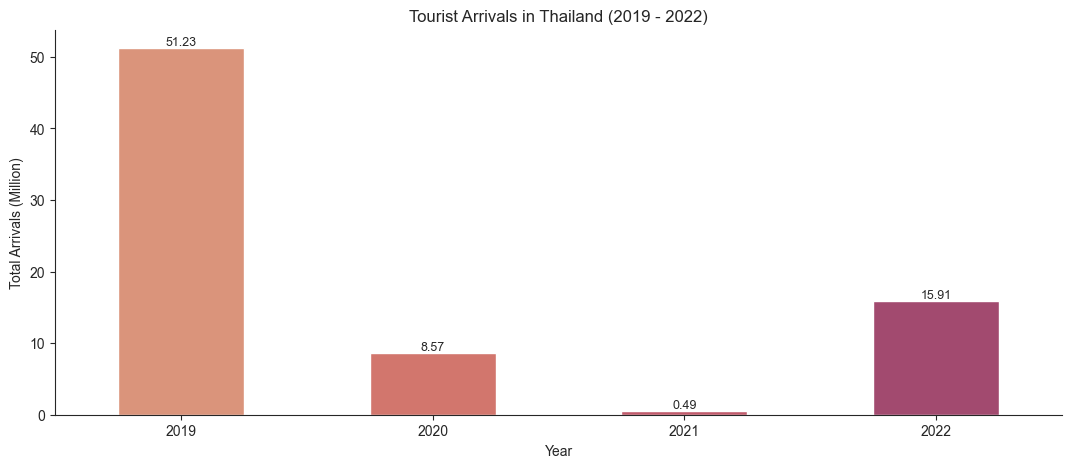

In [441]:
sns.set_style('white',{'ytick.left':True,'xtick.bottom':True,'axes.spines.right': False,
 'axes.spines.top': False})

fig, ax = plt.subplots(1, 1, figsize=(13, 5))
color = sns.color_palette("flare")

sns.barplot(data=total_arrival_by_year, x='year', y='num_arrival',  width=0.5, dodge=False,
            palette=color)

for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=9,fmt='%1.2f')


ax.set_title('Tourist Arrivals in Thailand (2019 - 2022)')
ax.set_xlabel('Year',fontdict={'size':10})
ax.set_ylabel('Total Arrivals (Million)',fontdict={'size':10})

## The Number of travellers visiting Thailand from 2019-2022

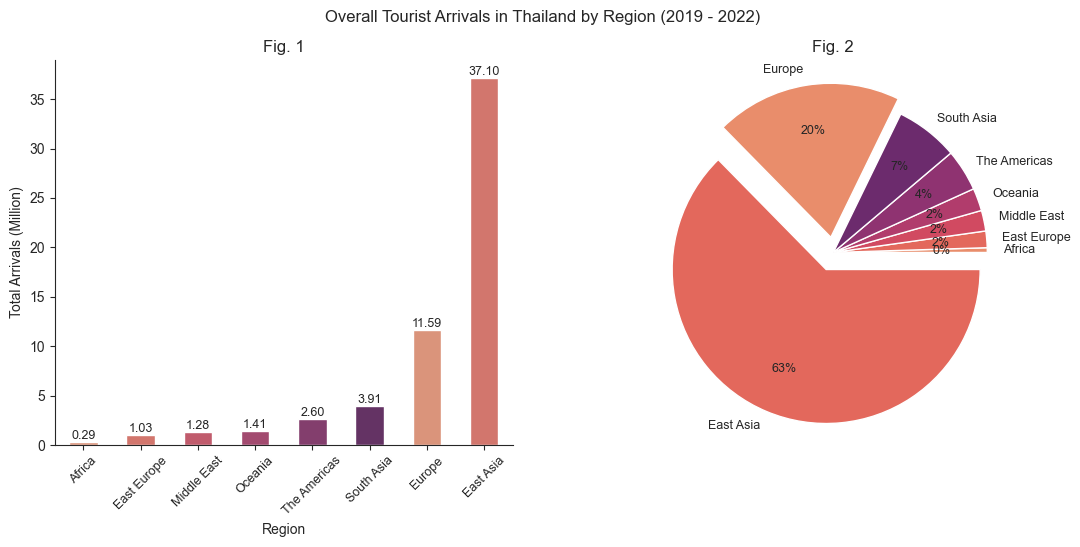

In [442]:
sns.set_style('white',{'ytick.left':True,'xtick.bottom':True,'axes.spines.right': False,
 'axes.spines.top': False})

fig, (axes1,axes2) = plt.subplots(1, 2, figsize=(13, 5))
color = sns.color_palette("flare")

sns.barplot(data=df_region_arrival, x='Nationality', y='Total Arrivals', hue='Nationality', ax = axes1, width=0.5, dodge=False,
            palette=color)


plt.pie(df_region_arrival['Total Arrivals'], labels=df_region_arrival['Nationality'], autopct='%.0f%%',
                colors=color,explode=[0,0,0,0,0,0,0.1,0.12],textprops={"fontsize":9},pctdistance=0.7)

for p in axes1.containers:
    axes1.bar_label(p, label_type='edge', fontsize=9,fmt='%1.2f')
axes1.set_xticklabels(axes1.get_xticklabels(), rotation=45,fontdict={'size':9})
axes1.legend([],[], frameon=False)
axes1.set_title('Fig. 1')
axes1.set_xlabel('Region',fontdict={'size':10})
axes1.set_ylabel('Total Arrivals (Million)',fontdict={'size':10})
axes2.set_title('Fig. 2')
fig.suptitle('Overall Tourist Arrivals in Thailand by Region (2019 - 2022)')
plt.show()

East Asia and Europe have the highest contribution amoung other regions. East asia and Europe have contributed for 63% and 20% respectively.

## East Asia

Based on the pie chart provided, it is evident that Chinese and Malaysian tourists have been the top two groups to visit Thailand in the past four years. As a result, this section will focus on analyzing the impact of these two countries on the Thai economy.

Text(0.5, 1.0, 'Proportion of Tourist Arrivals from East Asia')

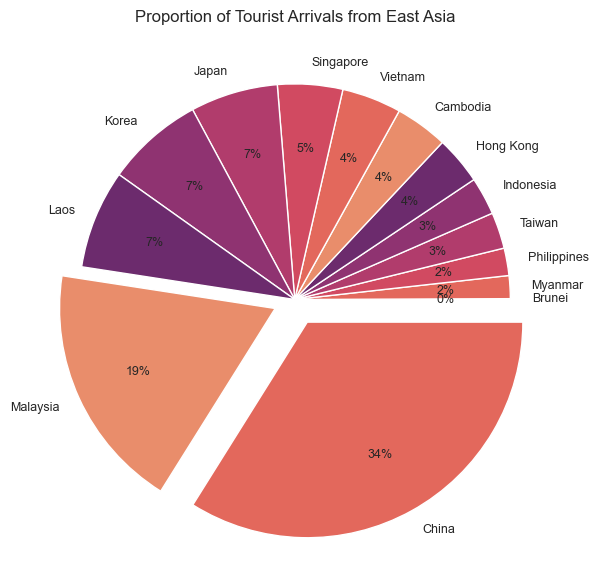

In [443]:
east_asian = percent_change[percent_change['Nationality'].isin(region_dict['East Asia'])]
east_asian = east_asian.groupby('Nationality')['num_arrival'].sum().sort_values().reset_index()

explode=[0,0,0,0,0,0,0,0,0,0,0,0,0.1,0.12]
color = sns.color_palette("flare")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax = plt.pie(east_asian['num_arrival'], labels=east_asian['Nationality'], autopct='%.0f%%',
             colors=color,textprops={"fontsize":9},pctdistance=0.7,explode=explode)
plt.title("Proportion of Tourist Arrivals from East Asia",fontdict={'fontsize':12})

## China

### What was the change to the number of Chinese travellers since the pandamic? from 2019-2022


/var/folders/64/b9lft99n3z7f93x2yz_nmxzr0000gn/T/ipykernel_17137/1931198734.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  china_expend['diff'].iloc[0] = china_expend['Total Spend (Mil. Baht)'].iloc[0]
/Users/itthisak/Desktop/Nida/dads_5001_mini_project/dads_5001_mini_project/lib/python3.10/site-packages/waterfall_chart.py:71: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


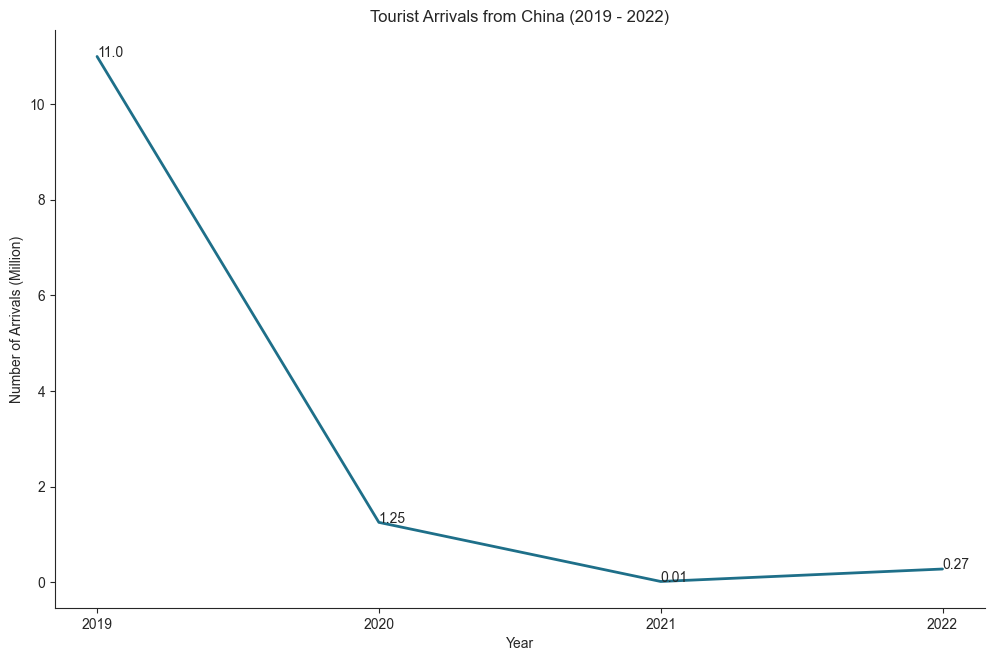

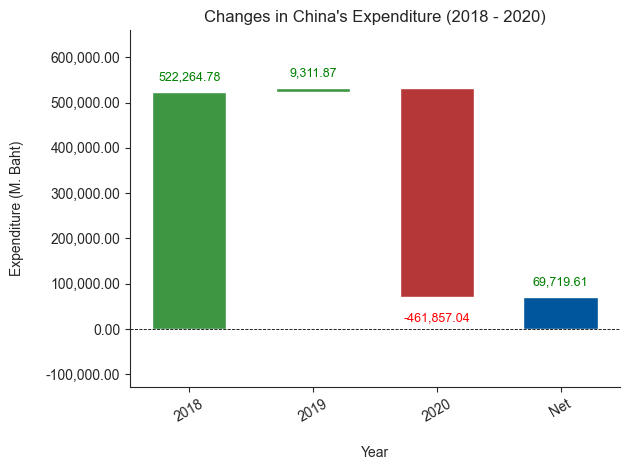

In [444]:
China_num = percent_change[percent_change['Nationality'] == 'China'].reset_index()

china_expend['diff'] = china_expend['Total Spend (Mil. Baht)'].diff()
china_expend['diff'].iloc[0] = china_expend['Total Spend (Mil. Baht)'].iloc[0]
china_expend['year'] = china_expend['year'].astype(str)

# Create the subplots
fig, (axes1) = plt.subplots(1, 1, figsize=(12, 7.5))

# First subplot: line plot of num_arrival over the years
axes1.plot(China_num['year'], China_num['num_arrival'],color='#1E6F89',linewidth = 2)
axes1.set_title('Number of arrivals from China')
axes1.set_xlabel('Year')
axes1.set_ylabel('Number of arrivals')

# Add annotations for base_pct_change values
for x, y in zip(China_num['year'], China_num['num_arrival']):
    axes1.annotate(f'{round(y, 2)}', xy=(x, y), textcoords='data')

axes1.set_title('Tourist Arrivals from China (2019 - 2022)')
axes1.set_xlabel('Year')
axes1.set_ylabel('Number of Arrivals (Million)')

# Second subplot: waterfall chart
# Plot

waterfall_china = waterfall_chart.plot(china_expend['year'], china_expend['diff'], formatting="{:,.2f}", 
                                  net_label="Net",
                                  blue_color="#00569D",
                                  green_color="#3E9542",
                                  red_color="#B53737",
                                  Title="Changes in China's Expenditure (2018 - 2020)",
                                  x_lab = "Year", y_lab = "Expenditure (M. Baht)")


##axes2.set_ylim(min(China_num_19_21['num_arrival']), max(China_num_19_21['num_arrival']))
plt.show()

# Malaysia

/var/folders/64/b9lft99n3z7f93x2yz_nmxzr0000gn/T/ipykernel_17137/656380680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Malay_expend['diff'].iloc[0] = Malay_expend['Total Spend (Mil. Baht)'].iloc[0]
/Users/itthisak/Desktop/Nida/dads_5001_mini_project/dads_5001_mini_project/lib/python3.10/site-packages/waterfall_chart.py:71: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


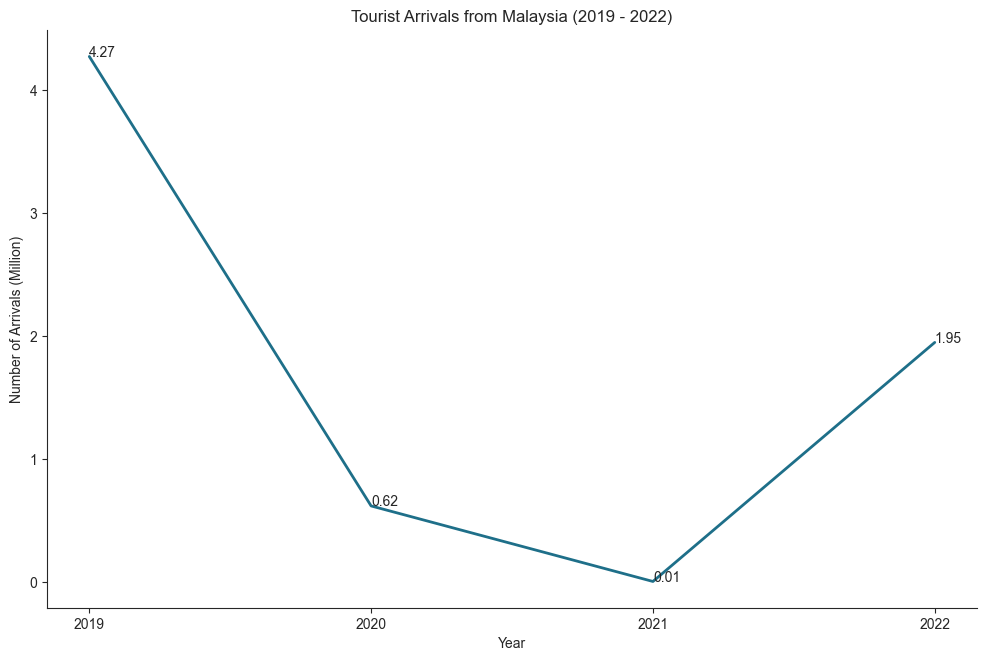

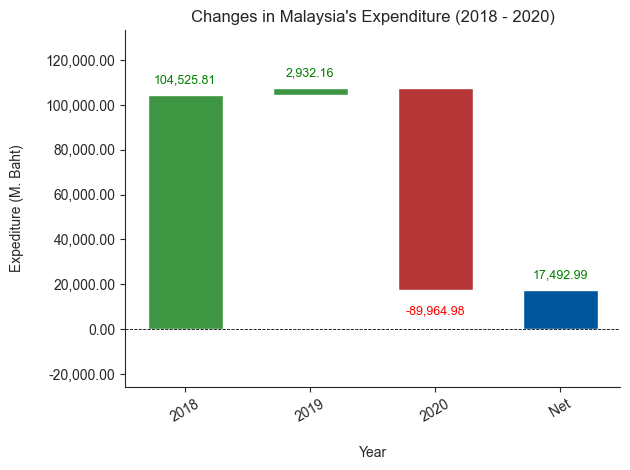

In [445]:
Malay_num = percent_change[percent_change['Nationality'] == 'Malaysia'].reset_index()
Malay_expend['diff'] = Malay_expend['Total Spend (Mil. Baht)'].diff()
Malay_expend['diff'].iloc[0] = Malay_expend['Total Spend (Mil. Baht)'].iloc[0]
Malay_expend['year'] = Malay_expend['year'].astype(str)


# Create the subplots
fig, axes1 = plt.subplots(1, 1, figsize=(12, 7.5))

# First subplot: line plot of num_arrival over the years
axes1.plot(Malay_num['year'], Malay_num['num_arrival'],color='#1E6F89',linewidth = 2)
axes1.set_title('Tourist Arrivals from Malaysia (2019 - 2022)')
axes1.set_xlabel('Year')
axes1.set_ylabel('Number of Arrivals (Million)')

# Add annotations for base_pct_change values
for x, y in zip(Malay_num['year'], Malay_num['num_arrival']):
    axes1.annotate(f'{round(y, 2)}', xy=(x, y), textcoords='data')


# Second subplot: waterfall chart
# Plot
##waterfall_chart.plot(Malay_num_19_21['year'],Malay_num_19_21['diff'],formatting="{:,.3f}")

waterfall_china = waterfall_chart.plot(Malay_expend['year'], Malay_expend['diff'], formatting="{:,.2f}", 
                                  net_label="Net",
                                  blue_color="#00569D",
                                  green_color="#3E9542",
                                  red_color="#B53737",
                                  Title="Changes in Malaysia's Expenditure (2018 - 2020)",
                                  x_lab = "Year", y_lab = "Expediture (M. Baht)")

plt.show()


### Discuss about income from Malaysian travellers

## Europe

Considering the first contribution
* what nationality has entered Thailand the most from 2019-2022 (focus on the top three)
* How much money there countries in point 1 had spent in Thailand during the stay?
* See the relationship on how Covid had effected these people coming to Thailand?
* 


Text(0.5, 1.0, 'Proportion of Tourist Arrivals from Europe')

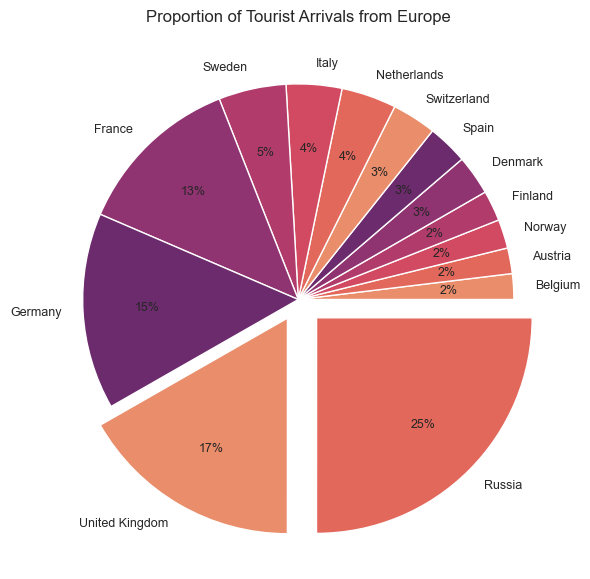

In [446]:
europe = percent_change[percent_change['Nationality'].isin(region_dict['Europe'])]
europe = europe.groupby('Nationality')['num_arrival'].sum().sort_values().reset_index()

explode=[0,0,0,0,0,0,0,0,0,0,0,0,0.1,0.12]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax = plt.pie(europe['num_arrival'], labels=europe['Nationality'], autopct='%.0f%%',
             colors=color,textprops={"fontsize":9},pctdistance=0.7,explode=explode)
plt.title("Proportion of Tourist Arrivals from Europe",fontdict={'fontsize':12})

## Russia

/var/folders/64/b9lft99n3z7f93x2yz_nmxzr0000gn/T/ipykernel_17137/2908189364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ru_expend['diff'].iloc[0] = ru_expend['Total Spend (Mil. Baht)'].iloc[0]
/Users/itthisak/Desktop/Nida/dads_5001_mini_project/dads_5001_mini_project/lib/python3.10/site-packages/waterfall_chart.py:71: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


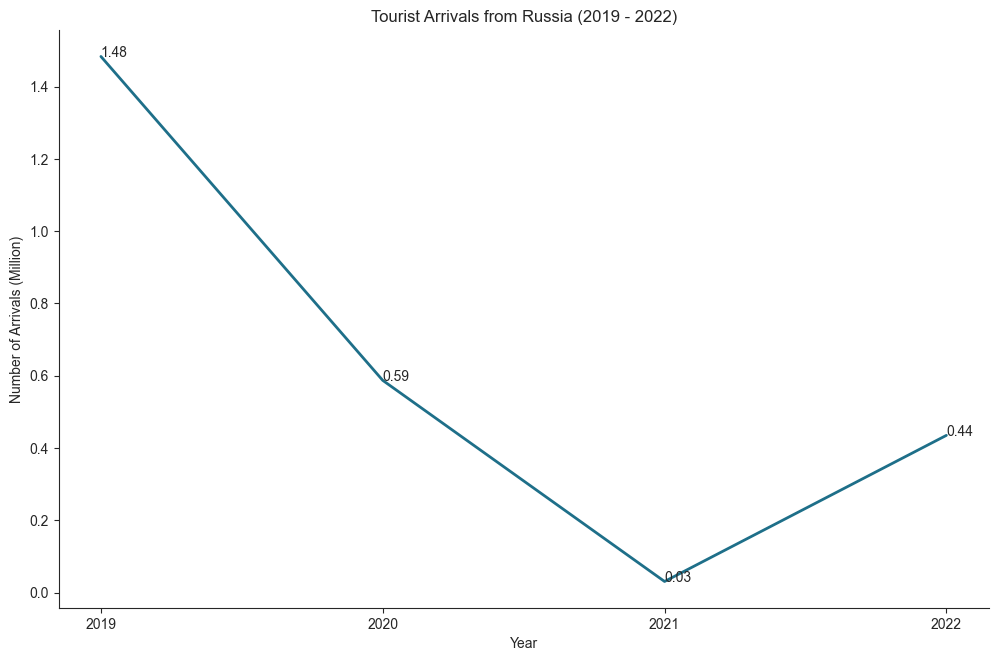

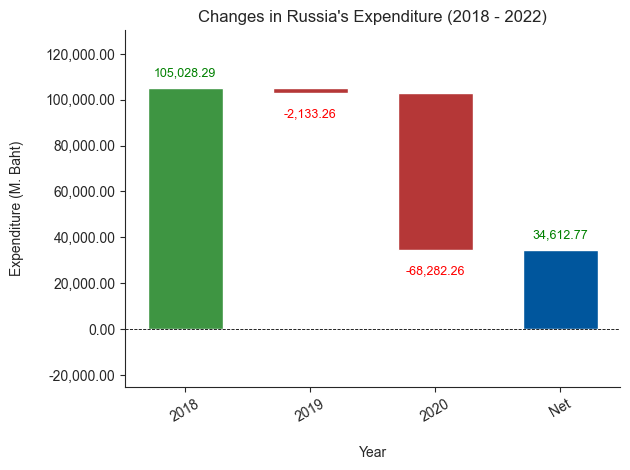

In [447]:
Russia = percent_change[percent_change['Nationality'] == 'Russia'].reset_index()
ru_expend['diff'] = ru_expend['Total Spend (Mil. Baht)'].diff()
ru_expend['diff'].iloc[0] = ru_expend['Total Spend (Mil. Baht)'].iloc[0]
ru_expend['year'] = ru_expend['year'].astype(str)



# Create the subplots
fig, axes1 = plt.subplots(1, 1, figsize=(12, 7.5))

# First subplot: line plot of num_arrival over the years
axes1.plot(Russia['year'], Russia['num_arrival'],color='#1E6F89',linewidth = 2)

axes1.set_title('Tourist Arrivals from Russia (2019 - 2022)')
axes1.set_xlabel('Year')
axes1.set_ylabel('Number of Arrivals (Million)')

# Add annotations for base_pct_change values
for x, y in zip(Russia['year'], Russia['num_arrival']):
    axes1.annotate(f'{round(y, 2)}', xy=(x, y), textcoords='data')


# Second subplot: waterfall chart
# Plot
waterfall_russia = waterfall_chart.plot(ru_expend['year'], ru_expend['diff'], formatting="{:,.2f}", 
                                  net_label="Net",
                                  blue_color="#00569D",
                                  green_color="#3E9542",
                                  red_color="#B53737",
                                  Title="Changes in Russia's Expenditure (2018 - 2022)",
                                  x_lab = "Year", y_lab = "Expenditure (M. Baht)")

##axes2.set_ylim(min(China_num_19_21['num_arrival']), max(China_num_19_21['num_arrival']))
plt.show()

# UK

/var/folders/64/b9lft99n3z7f93x2yz_nmxzr0000gn/T/ipykernel_17137/4260887680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_expend['diff'].iloc[0] = uk_expend['Total Spend (Mil. Baht)'].iloc[0]
/Users/itthisak/Desktop/Nida/dads_5001_mini_project/dads_5001_mini_project/lib/python3.10/site-packages/waterfall_chart.py:71: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


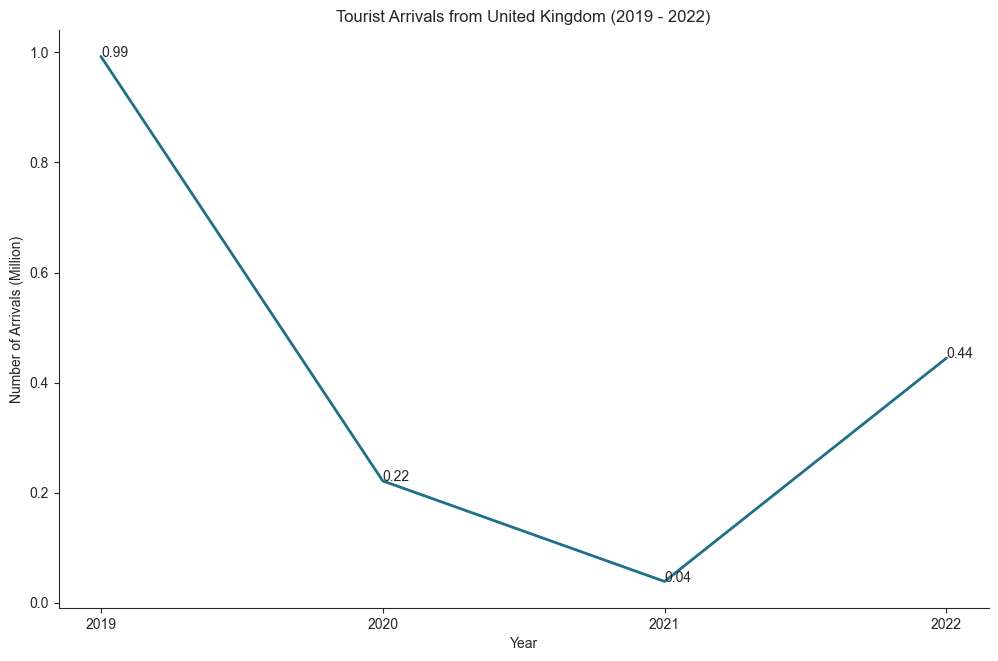

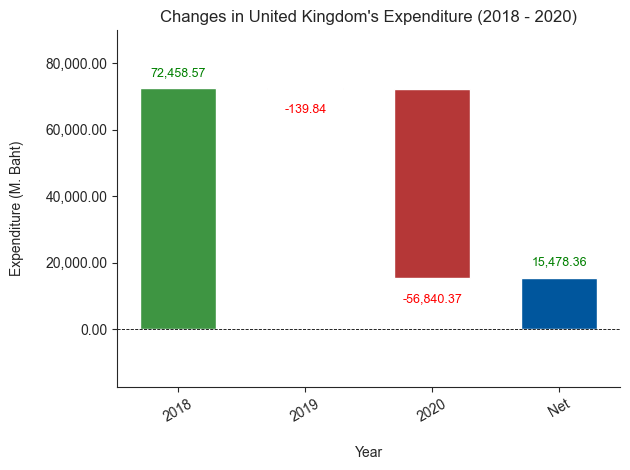

In [448]:
uk = percent_change[percent_change['Nationality'] == 'United Kingdom'].reset_index()
uk_expend['diff'] = uk_expend['Total Spend (Mil. Baht)'].diff()
uk_expend['diff'].iloc[0] = uk_expend['Total Spend (Mil. Baht)'].iloc[0]
uk_expend['year'] = uk_expend['year'].astype(str)



# Create the subplots
fig, axes1 = plt.subplots(1, 1, figsize=(12, 7.5))

# First subplot: line plot of num_arrival over the years
axes1.plot(uk['year'], uk['num_arrival'],color='#1E6F89',linewidth = 2)
axes1.set_title('Number of arrivals from UK')
axes1.set_xlabel('Year')
axes1.set_ylabel('Number of arrivals')

# Add annotations for base_pct_change values
for x, y in zip(uk['year'], uk['num_arrival']):
    axes1.annotate(f'{round(y, 2)}', xy=(x, y), textcoords='data')

axes1.set_title('Tourist Arrivals from United Kingdom (2019 - 2022)')
axes1.set_xlabel('Year')
axes1.set_ylabel('Number of Arrivals (Million)')

# Second subplot: waterfall chart
# Plot
waterfall_china = waterfall_chart.plot(uk_expend['year'], uk_expend['diff'], formatting="{:,.2f}", 
                                  net_label="Net",
                                  blue_color="#00569D",
                                  green_color="#3E9542",
                                  red_color="#B53737",
                                  Title="Changes in United Kingdom's Expenditure (2018 - 2020)",
                                  x_lab = "Year", y_lab = "Expenditure (M. Baht)")

##axes2.set_ylim(min(China_num_19_21['num_arrival']), max(China_num_19_21['num_arrival']))
plt.show()

In [449]:
top_visitor = pd.DataFrame()
top_visitor = pd.concat([top_visitor,china_expend,Malay_expend,ru_expend,uk_expend])
top_visitor.rename(columns={'diff':'Expenditure Change (M. Baht)','Total Spend (Mil. Baht)':'Total Spend (M. Baht)','year':'Year'},inplace=True)

In [450]:
top_visitor.groupby('Country')['Total Spend (M. Baht)'].sum().reset_index().sort_values(by=['Total Spend (M. Baht)'],ascending=False)

,Country,Total Spend (M. Baht)
0,China,1123561.04
2,Russia,242536.09
1,Malaysia,229476.77
3,United Kingdom,160255.66


In [451]:
top_visitor.groupby('Country')[['Spending per Capita (Baht/Day)','Length of Stay (Days)']].mean().reset_index()

,Country,Spending per Capita (Baht/Day),Length of Stay (Days)
0,China,5841.996667,8.473333
1,Malaysia,4528.530000,5.933333
2,Russia,3880.556667,16.746667
3,United Kingdom,3873.170000,18.110000


In [452]:
top_visitor.loc[top_visitor['Year'] == '2020',['Country','Year','Expenditure Change (M. Baht)']]

,Country,Year,Expenditure Change (M. Baht)
0,China,2020,-461857.04
0,Malaysia,2020,-89964.98
0,Russia,2020,-68282.26
0,United Kingdom,2020,-56840.37
